Thymio mini project

In [1]:
!pip install --upgrade tdmclient

In [2]:
# import libraries
import time
from tdmclient import ClientAsync
import numpy as np
import math

# import project files
import constants as cst
import vision
import global_navigation as gn
#import local_navigation as ln
import extended_Kalman_filter as eKf
import geometry as geo

#connect to the robot
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

-1.5707963267948966


Node 328bdb70-11b8-49f9-b631-ac6519113084

In [3]:
await node.set_variables({
            'leds.bottom.left': [0, 0, 0],
            'leds.bottom.right': [0, 0, 0],
            'leds.circle': [0, 0, 0, 0, 0, 0, 0, 0],
            'leds.top': [0, 0, 0],
        })

In [4]:
# Set the motor speeds
async def stop_robot():
    """
    Stop the robot. Set the motor speed of each wheel to zero.
    """
    await node.set_variables({
            "motor.right.target": [0],
            "motor.left.target": [0],
        })

async def move_robot(right_speed, left_speed):
    """
    Turn the robot wheels to the given speeds.
    Parameter: - right_speed   : right wheel speed in [thymio speed]
               - left_speed    : left wheel speed in [thymio speed]
    """
    await node.set_variables({
            "motor.right.target": [right_speed],
            "motor.left.target": [left_speed],
        })

In [5]:
# Get the proximity sensor values
async def get_prox_sensors():
    """
    Get the sensor measurements of a the proximity sensors.
    Returns: - prox_sensors    : numpy array of fron proximity sensors measurements
             - detected        : boolean, true if any sensors measured a higher value than threshold
    """
    
    await node.wait_for_variables({str('prox.horizontal')})
    prox_sensors = np.asarray(list(node['prox.horizontal']))
    prox_sensors = prox_sensors[0:5]

    prox_sensors_bool = (prox_sensors >= np.ones(5) * 20) #cst.THRESHOLD_PROX_SENSOR
    detected = False
    if(any(prox_sensors_bool)):
        detected = True

    return prox_sensors, detected

# Get the motor speed measurement values
async def get_motor_speed_meas():
    """
    Get the motor speed measurements
    Returns: - speed_left_meas    : left wheel speed in [thymio speed]
             - speed_right_meas   : right wheel speed in [thymio speed]
    """
    
    await node.wait_for_variables({str('motor.right.speed')})
    speed_right_meas = node['motor.right.speed']
    await node.wait_for_variables({str('motor.left.speed')})
    speed_left_meas = node['motor.left.speed']

    return speed_right_meas, speed_left_meas

In [6]:
# test thymio
# move the robot forward and get prox values.
await move_robot(50, 50)
dt = 0
old_time = time.time()
while(dt < 2):
    y,d = await get_prox_sensors()
    print(y)
    print(d)
    await client.sleep(0.1)
    dt = time.time() - old_time
await stop_robot()

[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False


Coordonnées obstacles noirs : [[(757, 779), (1030, 779), (1030, 319), (757, 319)]]
Centroid de la goal area : [1499.   533.5]
Vecteur direction du robot : 100 0
Centroid du robot : [516 548]


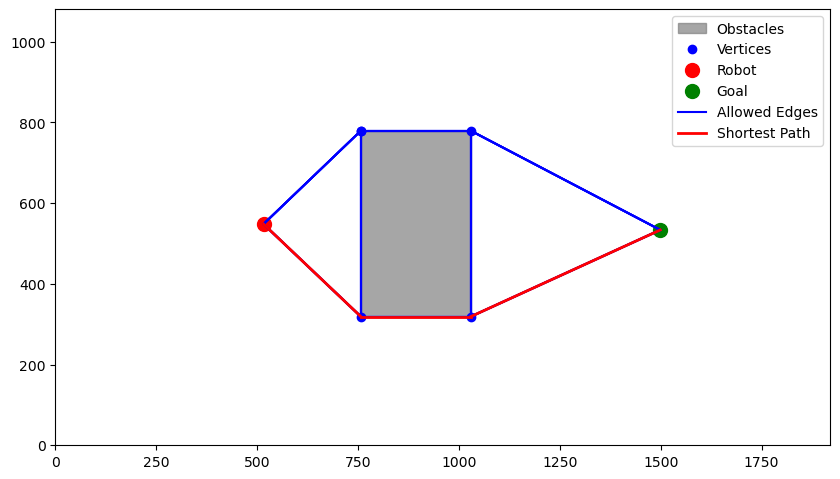

glob nav path : [(516.0, 548.0), (757.0, 319.0), (1030.0, 319.0), (1499.0, 533.5)]
(27, 29)
[(27, 29), (40, 17), (55, 17), (81, 28)]


In [7]:
#VISION AND GLOBAL NAVIGATION
obstacles, goal_centroid = vision.vision_obstacles_and_goal()
robot_centroid, robot_direction = vision.vision_robot()

merge_need = True
visualize = True
shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid), merge_need, visualize)
print("glob nav path :", shortest_path)


def pixels_to_cm(coordinates, pixel_to_cm_ratio=0.05406):
    # Convert each coordinate in the list or individual point
    if isinstance(coordinates[0], (list, tuple)):
        # List of coordinates
        converted_coordinates = [
            (int(x * pixel_to_cm_ratio), int(y * pixel_to_cm_ratio)) for x, y in coordinates
        ]
    else:
        # Single coordinate
        converted_coordinates = (int(coordinates[0] * pixel_to_cm_ratio), int(coordinates[1] * pixel_to_cm_ratio))
    
    return converted_coordinates



shortest_path = pixels_to_cm(shortest_path)


robot_centroid = pixels_to_cm(robot_centroid)
print(robot_centroid)
print(shortest_path)

#obstacles = np.array(obstacles)

1 rotation
5 4    0.0 0.0
[3.41790629e-13] [-0.74541948] [-0.74541948]
2 rotation
-20 21    -30 30
[-0.01820033] [-0.76859314] [-0.7503928]
3 rotation
-29 27    -30 30
[-0.12595867] [-0.77617339] [-0.65021472]
4 rotation
-29 29    -30 30
[-0.28262152] [-0.77811882] [-0.4954973]
5 rotation
-29 33    -30 30
[-0.46312869] [-0.77970162] [-0.31657293]
6 rotation
-30 28    -30 30
[-0.65090014] [-0.77995231] [-0.12905217]
7 rotation
-28 27    -30 30
[-0.83448689] [-0.77983124] [0.05465565]
8 translation
-24 8    -30 30
Error: [17.09227636]
9 translation
44 43    50 50
Error: [17.02058343]
10 translation
52 51    50 50
Error: [16.49079997]
11 translation
33 46    50 50
Error: [15.84215063]
12 translation
50 46    50 50
Error: [15.15033926]
13 translation
51 50    50 50
Error: [14.39688878]
14 translation
49 49    50 50
Error: [13.61980034]
15 translation
49 50    50 50
Error: [12.8406897]
16 translation
48 49    50 50
Error: [12.06656671]
17 translation
50 48    50 50
Error: [11.29983241]
18 t

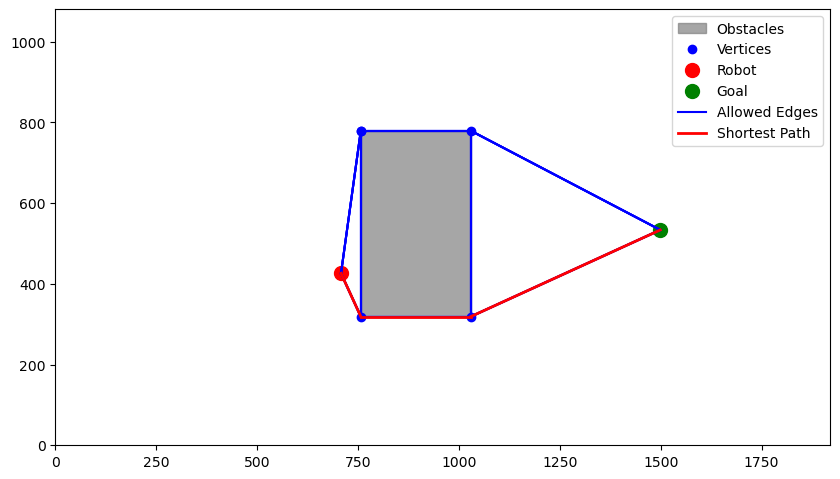

glob nav path : [(708.0, 426.0), (757.0, 319.0), (1030.0, 319.0), (1499.0, 533.5)]
(38, 23)
[(38, 23), (40, 17), (55, 17), (81, 28)]
27 rotation
3 1    50 50
Kalman:  35.400878327175526 16.99490233656282 -1.0067789353156158 0.4005807681889495 0.33555745784884017
[-1.00677894] [0.0002601] [1.00703903]
28 rotation
24 -22    30 -30
[-0.88061203] [0.00361906] [0.88423109]
29 rotation
29 -28    30 -30
[-0.73695057] [0.00574089] [0.74269146]
30 rotation
30 -29    30 -30
[-0.56945923] [0.00698086] [0.57644009]
31 rotation
30 -29    30 -30
[-0.38860225] [0.00774689] [0.39634914]
32 rotation
28 -28    30 -30
[-0.20619463] [0.00800342] [0.21419805]
33 rotation
29 -27    30 -30
[-0.02521311] [0.00832727] [0.03354038]
34 translation
29 -28    30 -30
Error: [19.46858252]
35 translation
39 39    50 50
Error: [19.24916252]
36 translation
48 42    50 50
Error: [18.72315064]
37 translation
48 49    50 50
Error: [18.04629491]
38 translation
48 46    50 50
Error: [17.31168471]
39 translation
49 47    50 

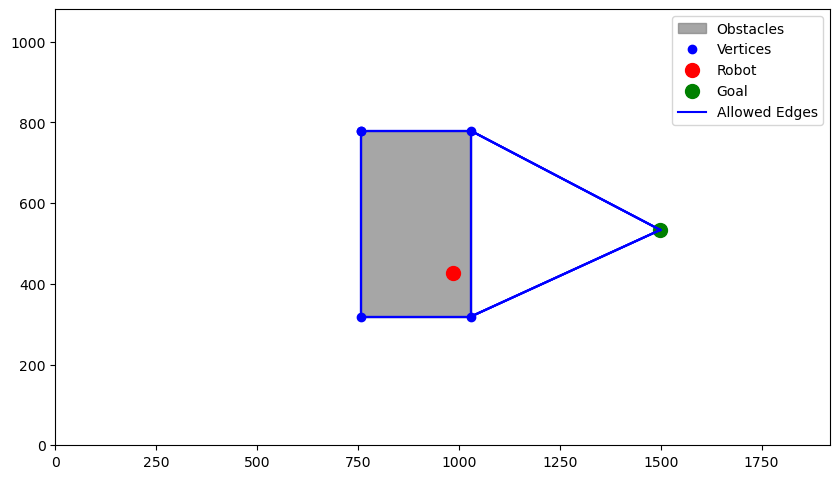

glob nav path : Path not reachable


TypeError: can't multiply sequence by non-int of type 'float'

In [8]:
#ROBOT CONTROL AND LOCALISATION

# state variables
global_state = 'rotation'

#speed_correction = 12.5 #calibration cst for rotation counterclockwise
speed_correction = 14 #calibration cst for rotation counterclockwise
#speed_correction = 0.75 #0.65 #calibration cst for translation

intermediate_goals = shortest_path
intermediate_goals.pop(0)
robot = [(robot_centroid[0],robot_centroid[1])]
robot_orientation = np.arctan2(robot_direction[1], robot_direction[0])

#intermediate_goals = [(0, 10), (-10, 10), (-10, 0), (0,0)]
#intermediate_goals = [(56, 34), (66, 34), (87, 26)]
#robot = [(34.0,28.0)]
#robot_orientation = 1.6
robot_speed = [0.0,0.0]

Kfilter = eKf.Kalman(robot[0][0], robot[0][1], robot_orientation)

#robot_speed = [30, -30] #robot speed for rotation (counterclockwise)
#robot_speed = [-30, 30] #robot speed for rotation (clockwise)
#robot_speed = [50, 50] #robot speed for translation
#await move_robot(robot_speed[0], robot_speed[1])

old_time = 0.0
printkal = False
iter = 0
while(True):
    iter = iter + 1
    print(iter, global_state)

    if intermediate_goals == []:
        await stop_robot()
        print("stop robot")
        break

    
    speed_right_meas, speed_left_meas = await get_motor_speed_meas()
    print(speed_right_meas, speed_left_meas, "  ", robot_speed[0], robot_speed[1])
    speed_right_meas = speed_right_meas * speed_correction
    speed_left_meas = speed_left_meas * speed_correction
    
    #speed_right_meas = robot_speed[0] * speed_correction
    #speed_left_meas = robot_speed[1] * speed_correction

    Kfilter.measurement_wheels(speed_right_meas / 18.1818, speed_left_meas / 18.1818)

    if iter == 0:                   # first time
        old_time = time.time()
    dt = time.time() - old_time     # get time difference for Kalman
    old_time = time.time()

    Kfilter.dt_update(dt)
    Kfilter.Kalman_filter()
    #print(dt, time.time(), old_time)
    if printkal:
        print("Kalman: ", Kfilter.Mu[0][0], Kfilter.Mu[1][0], Kfilter.Mu[2][0], Kfilter.Mu[3][0], Kfilter.Mu[4][0])
        printkal = False
    #print("Kalman Sigma: ", Kfilter.Sigma)
    #print("Kalman y: ", Kfilter.y)
    
    robot.append((Kfilter.Mu[0][0], Kfilter.Mu[1][0]))
    
    if global_state == 'rotation':
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = geo.center_angle(angle)
        print(Kfilter.Mu[2], np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]), angle)
        #if(abs(Kfilter.Mu[2][0]) > np.pi / 4.0):        #rotation condition
        if(abs(angle) < 0.08):
            await stop_robot()
            global_state = 'translation'
            continue

        if(angle > 0):
            robot_speed = [30, -30]         # counterclockwise
            speed_correction = 2 #32 #14
        else:
            robot_speed = [-30, 30]         # clockwise
            speed_correction = 2 #12.5

    elif global_state == 'translation':
        robot_speed = [50, 50]
        speed_correction = 0.75
        print("Error:", np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2))
        #if(np.sqrt(Kfilter.Mu[0][0]**2 + Kfilter.Mu[1][0]**2) > 10.0):     #translation condition
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= 6:
            print("je m'arrete")
            await stop_robot()
            intermediate_goals.pop(0)
            global_state = 'camera'
            continue
        
        
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = geo.center_angle(angle)
        if abs(angle) > math.pi / 4.0:
            await stop_robot()
            global_state = 'rotation'
            continue
        
        
    elif global_state == 'camera':
        robot_centroid = [0,0]
        while robot_centroid[0] == 0 and robot_centroid[1] == 0:
            robot_centroid, robot_direction = vision.vision_robot()
            
        #robot_centroid = pixels_to_cm(robot_centroid) #changer pixel
        robot_angle = np.arctan2(robot_direction[1], robot_direction[0])    
        #Kfilter.measurement_position(robot_centroid[0], robot_centroid[1], robot_angle)
        #print("Kalman: ", Kfilter.Mu[0][0], Kfilter.Mu[1][0], Kfilter.Mu[2][0], Kfilter.Mu[3][0], Kfilter.Mu[4][0])
        global_state = 'rotation'
        print("camera measurements: ", robot_centroid, robot_angle)
        printkal = True
        
        #obstacles, goal_centroid = vision.vision_obstacles_and_goal()
        #robot_centroid, robot_direction = vision.vision_robot()

        merge_need = True
        visualize = True
        shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid), merge_need, visualize)
        print("glob nav path :", shortest_path)

        shortest_path = pixels_to_cm(shortest_path)

        robot_centroid = pixels_to_cm(robot_centroid)
        print(robot_centroid)
        print(shortest_path)

        
        
        continue
        
    await move_robot(robot_speed[0], robot_speed[1])
    await client.sleep(0.3)


    

In [ ]:
await stop_robot()

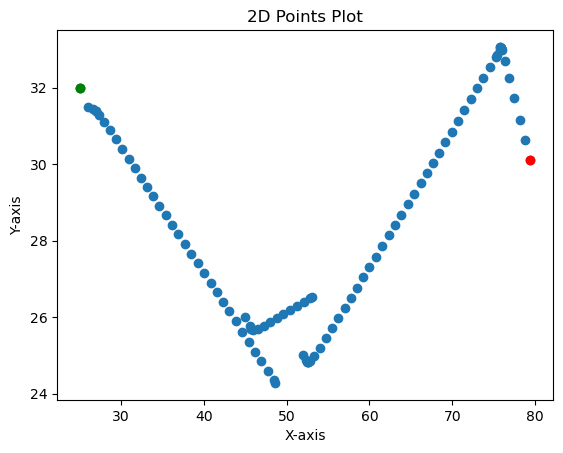

[(25, 32), (25.00000000001986, 31.99999999999874), (25.9672132907485, 31.503707613497276), (26.670575866527162, 31.44135231727119), (26.97308155645252, 31.397191413092294), (27.016323469672862, 31.376599080617094), (27.373852392809802, 31.289772250141745), (27.969167224385686, 31.108270396652678), (28.66081705635458, 30.88374317746476), (29.400070910576627, 30.642012780924667), (30.15239997296375, 30.39389991290144), (30.916218000221527, 30.14275476319224), (31.672337816821, 29.89113684591478), (32.41568748950998, 29.64449288145279), (33.154530403048426, 29.40193030407535), (33.89206009218986, 29.162322031364113), (34.64683021011187, 28.91527389089108), (35.41622558994967, 28.663595007863744), (36.18351455586227, 28.412183853031294), (36.94082734406697, 28.166101206262116), (37.70433048685202, 27.917279110242493), (38.479858283216004, 27.66217389028651), (39.264465736413335, 27.40858516418547), (40.04543356712341, 27.15534708262837), (40.8200132086329, 26.900066352006696), (41.57752545

In [10]:
import matplotlib.pyplot as plt

# Unpack the tuples into separate lists for x and y coordinates
x_coords, y_coords = zip(*robot)

# Plot the points
plt.scatter(x_coords, y_coords)
plt.scatter(robot[0][0], robot[0][1], color = "green")
plt.scatter(robot[-1][0], robot[-1][1], color = "red")

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Points Plot')

# Display the plot
plt.show()
print(robot)